# Machine Learning technique on PET block detector development - Part 2-2

## Crystal/Pixel discrimination for DQS PET block detector using Machine Learning techniques (v1.0, 2019-09)   
## (Continued from Part 2-1)
---


###  
### 6. Scintillator/Pixel discrimination using ML algorithms - Part II, using Non Linear models

In [2]:
# load libraries

import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
# %matplotlib qt
%matplotlib inline
# %matplotlib notebook

import pickle
from sklearn.externals import joblib
from sklearn import metrics
import time

plt.rcParams['figure.dpi'] = 120 # default is 72

In [3]:
# re-load data

file = "D:\\ML on PET block\\new_concept_block_lso\\new_concept_block_15x15\\results\\ML_data\\new_concept_block_15x15_sorted_events1.csv"
df0 = pd.read_csv (file, comment='#')

X = df0.iloc[:,4:].values
decoding = df0.iloc[:,0:4].values

E_top = X[:,0:18]
E_bottom = X[:,18:36]

E_x1 = E_top[:, 0:18:2]
E_x2 = E_top[:, 18:0:-2]

E_y1 = E_bottom[:, 0:18:2]
E_y2 = E_bottom[:, 18:0:-2]

E_left = np.sum(E_x1, axis = 1)
E_right = np.sum(E_x2, axis = 1)

E_front = np.sum(E_y1, axis = 1)
E_back = np.sum(E_y2, axis = 1)


In [4]:
infile = open('./pickle/temp_data1','rb')
X_t, X_b, X_a, X_g, X_c, index_train, index_test = pickle.load(infile)
infile.close()


In [5]:
# pixel_xy = np.array(df0['index_y'] * 15 + df0['index_x'])
pixel_x = np.array(df0['index_x'])
pixel_y = np.array(df0['index_y'])
pixel_xy = pixel_y * 15 + pixel_x

pixel_x_train = pixel_x[index_train]
pixel_y_train = pixel_y[index_train]
pixel_xy_train = pixel_xy[index_train]

pixel_x_test = pixel_x[index_test]
pixel_y_test = pixel_y[index_test]
pixel_xy_test = pixel_xy[index_test]


In [6]:
from sklearn.utils import check_random_state

def random_cmap(ncolors=256, random_state=None):
    """
    Generate a matplotlib colormap consisting of random (muted) colors.

    A random colormap is very useful for plotting segmentation images.

    Parameters
    ----------
    ncolors : int, optional
        The number of colors in the colormap.  The default is 256.

    random_state : int or `~numpy.random.RandomState`, optional
        The pseudo-random number generator state used for random
        sampling.  Separate function calls with the same
        ``random_state`` will generate the same colormap.

    Returns
    -------
    cmap : `matplotlib.colors.Colormap`
        The matplotlib colormap with random colors.
    """

    from matplotlib import colors

    prng = check_random_state(random_state)
    h = prng.uniform(low=0.0, high=1.0, size=ncolors)
    s = prng.uniform(low=0.4, high=0.9, size=ncolors)
    v = prng.uniform(low=0.7, high=1.0, size=ncolors)
    hsv = np.dstack((h, s, v))
    rgb = np.squeeze(colors.hsv_to_rgb(hsv))

    return colors.ListedColormap(rgb)

In [7]:

def generate_grid(lut):
    """
    generate the grid of the lookup table from the lookup table data
    
    input: lookup table, numpy array
    output: grid as numpy array, the same size as the input 
    """
    
    lut_grid = np.zeros(lut.shape)
    pix_x, pix_y = lut_grid.shape

    for i in range(pix_x-1):
        for j in range(pix_y-1):
            if lut[i,j] != lut[i+1,j]:
                lut_grid[i,j] = 1
                lut_grid[i+1,j] = 1
            if lut[i,j] != lut[i,j+1]:
                lut_grid[i,j] = 1
                lut_grid[i,j+1] = 1
    
    return lut_grid

####  
#### 6.1 pixel discrimination using decision tree classification algorithms - using seperated x and y indices as the output

In [47]:
from sklearn.tree import DecisionTreeClassifier

In [49]:
def tree_fit(X, y, clf):
    clf.fit(X,y)
    return clf

In [24]:
def plot_prediction_boundary2(reg_func1, reg_func2, cmap='hsv', alpha=1, axes=[0, 1.0, 0, 1.0], title=''):
    '''
    fitting the data with two functions, one for the x-axis and the other for the y-axis
    '''
    fig, ax = plt.subplots(figsize=(4,4))
    
    x1s = np.linspace(axes[0], axes[1], 256)
    x2s = np.linspace(axes[2], axes[3], 256)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y1_pred = reg_func1.predict(X_new).reshape(x1.shape)
    y2_pred = reg_func2.predict(X_new).reshape(x1.shape)

    lut_pred = y1_pred+y2_pred*15
    plt.imshow(lut_pred, alpha=alpha, cmap=cmap)
    plt.title(title)
    
    return lut_pred


In [17]:
def test_tree_classifier(X, y, index_train, index_test, depth):

    X_train = X[index_train]
    X_test = X[index_test]
    y1 = y[:,0]
    y2 = y[:,1]
    
    for tree_depth in depth:

        tree_clf1 = DecisionTreeClassifier(max_depth=tree_depth, random_state=0)
        tree_clf2 = DecisionTreeClassifier(max_depth=tree_depth, random_state=0)

        tree_fit(X_train, y1[index_train], tree_clf1)
        tree_fit(X_train, y2[index_train], tree_clf2)

        pixel_x_pred = tree_clf1.predict(X_test)
        pixel_y_pred = tree_clf2.predict(X_test)

        accuracy = sum(np.logical_and(y[index_test,0]==pixel_x_pred, y[index_test,1]==pixel_y_pred)) / index_test.size
        print('accuracy from tree classification (max_depth=%d): %f' % (tree_depth,accuracy))
        
    return tree_clf1, tree_clf2


In [21]:

y = np.c_[df0['index_x'].ravel(), df0['index_y'].ravel()]

for X, notes in ((X_t,'Anger docoding'), ( X_b, 'Light Channel decoding'), \
                 (X_a,'Arithmatic mean'), (X_g,'Geometric mean'), \
                 (X_c,'Complex weight function')):
    print ('=== %s ==='%notes)
    clf1, clf2 = test_tree_classifier(X, y, index_train, index_test,depth=[2,3,4,5,6,7])
#    plot_prediction_boundary2(clf1, clf2, cmap=random_cmap())


=== Anger docoding ===
accuracy from tree classification (max_depth=2): 0.069414
accuracy from tree classification (max_depth=3): 0.208087
accuracy from tree classification (max_depth=4): 0.495856
accuracy from tree classification (max_depth=5): 0.497650
accuracy from tree classification (max_depth=6): 0.497734
accuracy from tree classification (max_depth=7): 0.497982
=== Light Channel decoding ===
accuracy from tree classification (max_depth=2): 0.070344
accuracy from tree classification (max_depth=3): 0.218346
accuracy from tree classification (max_depth=4): 0.491528
accuracy from tree classification (max_depth=5): 0.501557
accuracy from tree classification (max_depth=6): 0.508955
accuracy from tree classification (max_depth=7): 0.523365
=== Arithmatic mean ===
accuracy from tree classification (max_depth=2): 0.071137
accuracy from tree classification (max_depth=3): 0.224650
accuracy from tree classification (max_depth=4): 0.521066
accuracy from tree classification (max_depth=5): 0.5

=== Anger docoding ===  
accuracy from tree classification (max_depth=2): 0.069414  
accuracy from tree classification (max_depth=3): 0.208087  
accuracy from tree classification (max_depth=4): 0.495856  
accuracy from tree classification (max_depth=5): 0.497650  
accuracy from tree classification (max_depth=6): 0.497734  
accuracy from tree classification (max_depth=7): 0.497982  
=== Light Channel decoding ===  
accuracy from tree classification (max_depth=2): 0.070344  
accuracy from tree classification (max_depth=3): 0.218346  
accuracy from tree classification (max_depth=4): 0.491528  
accuracy from tree classification (max_depth=5): 0.501557  
accuracy from tree classification (max_depth=6): 0.508955  
accuracy from tree classification (max_depth=7): 0.523365  
=== Arithmatic mean ===  
accuracy from tree classification (max_depth=2): 0.071137  
accuracy from tree classification (max_depth=3): 0.224650  
accuracy from tree classification (max_depth=4): 0.521066  
accuracy from tree classification (max_depth=5): 0.558457  
accuracy from tree classification (max_depth=6): 0.563538  
accuracy from tree classification (max_depth=7): 0.566103  
=== Geometric mean ===  
accuracy from tree classification (max_depth=2): 0.070982  
accuracy from tree classification (max_depth=3): 0.225265  
accuracy from tree classification (max_depth=4): 0.504764  
accuracy from tree classification (max_depth=5): 0.573199  
accuracy from tree classification (max_depth=6): 0.575184  
accuracy from tree classification (max_depth=7): 0.575582  
=== Complex weight function ===  
accuracy from tree classification (max_depth=2): 0.070942  
accuracy from tree classification (max_depth=3): 0.210882  
accuracy from tree classification (max_depth=4): 0.473003  
accuracy from tree classification (max_depth=5): 0.503214  
accuracy from tree classification (max_depth=6): 0.512162  
accuracy from tree classification (max_depth=7): 0.528906  

=== Anger docoding ===
accuracy from tree classification (max_depth=7): 0.497982
=== Light Channel decoding ===
accuracy from tree classification (max_depth=7): 0.523365
=== Arithmatic mean ===
accuracy from tree classification (max_depth=7): 0.566103
=== Geometric mean ===
accuracy from tree classification (max_depth=7): 0.575582
=== Complex weight function ===
accuracy from tree classification (max_depth=7): 0.528906


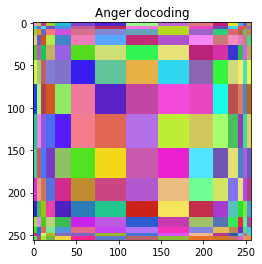

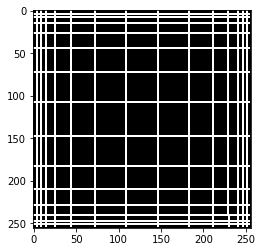

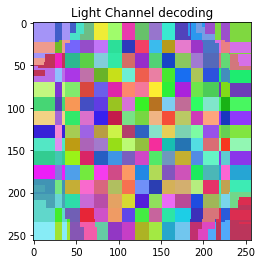

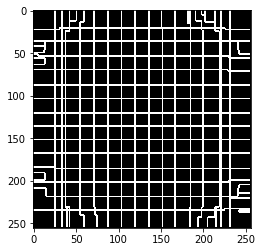

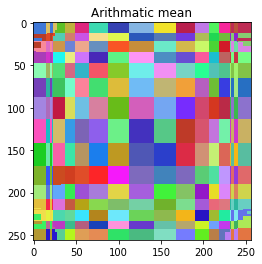

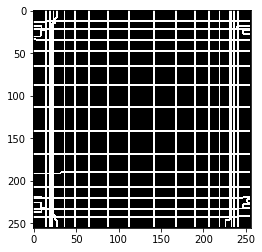

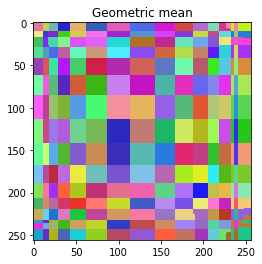

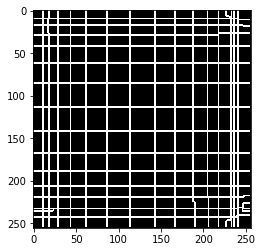

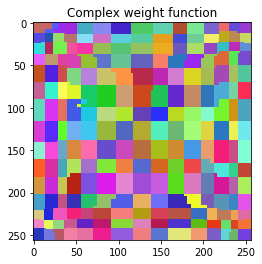

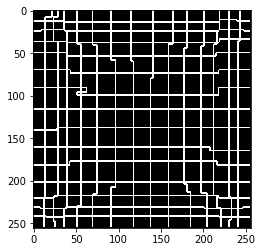

In [29]:
y = np.c_[df0['index_x'].ravel(), df0['index_y'].ravel()]

for X, notes in ((X_t,'Anger docoding'), ( X_b, 'Light Channel decoding'), \
                 (X_a,'Arithmatic mean'), (X_g,'Geometric mean'), \
                 (X_c,'Complex weight function')):
    print ('=== %s ==='%notes)
    clf1, clf2 = test_tree_classifier(X, y, index_train, index_test,depth=[7])
    lut_pred = plot_prediction_boundary2(clf1, clf2, cmap=random_cmap(), title=notes)
    plt.figure()
    plt.imshow(generate_grid(lut_pred), cmap='gray')

In [48]:
# interactive mode to check the prediction/decoding
%matplotlib qt

fig_i, ax = plt.subplots(figsize=(4,4))

x1s = np.linspace(0, 1, 256)
x2s = np.linspace(0, 1, 256)
x1, x2 = np.meshgrid(x1s, x2s)
X_new = np.c_[x1.ravel(), x2.ravel()]
y1_pred = clf1.predict(X_new).reshape(x1.shape)
y2_pred = clf2.predict(X_new).reshape(x1.shape)

lut_pred = y1_pred+y2_pred*15
ax.imshow(lut_pred, alpha=1.0, cmap='prism')

def onclick(event):
    X1 = [[event.xdata/255, event.ydata/255]]
    y1 = clf1.predict(X1)
    y2 = clf2.predict(X1)
    print(y1, y2, y1+y2*15)

cid_mouse_press = fig_i.canvas.mpl_connect('button_press_event', onclick)
        
fig_i.show()


In [49]:
%matplotlib inline
# %matplotlib notebook


* <b>Using tree classification algorithm, the accuracy could reach 0.56 - 0.57 for the arithmatic mean and geometric mean decoding, which exceed the results from lookup table and polynomial regression.</b>

####  
#### 6.2 pixel discrimination using decision tree classification algorithms - using combined xy index as the output

In [12]:
def plot_prediction_boundary3(reg_func, cmap='hsv', alpha=1, axes=[0, 1.0, 0, 1.0], title='', ax=None):
    '''
    fitting the data with one function, the prediction is the unique pixel index
    '''
    if ax == None:
        fig, ax = plt.subplots(figsize=(4,4))
    
    x1s = np.linspace(axes[0], axes[1], 256)
    x2s = np.linspace(axes[2], axes[3], 256)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    pixel_xy_pred = reg_func.predict(X_new).reshape(x1.shape)

    lut_pred = pixel_xy_pred
    ax.imshow(lut_pred, alpha=alpha, cmap=cmap)
    ax.set_title(title)
        
        
    return lut_pred

In [44]:
def test_tree_classifier2(X, y, index_train, index_test, depth):
    '''
    output y is the unique pixel index pixel_xy
    '''

    X_train = X[index_train]
    X_test = X[index_test]
    

    tree_clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
    tree_fit(X_train, y[index_train], tree_clf)
    pixel_xy_pred = tree_clf.predict(X_test)

    accuracy = sum(y[index_test]==pixel_xy_pred) / index_test.size
    print('accuracy from tree classification (max_depth=%d): %f' % (depth,accuracy))

    return tree_clf

In [12]:
y = df0['index_x'].ravel() + df0['index_y'].ravel()*15

=== Anger docoding ===
accuracy from tree classification (max_depth=3): 0.034884
accuracy from tree classification (max_depth=5): 0.120963
accuracy from tree classification (max_depth=7): 0.342024
accuracy from tree classification (max_depth=9): 0.495984
accuracy from tree classification (max_depth=11): 0.494771
accuracy from tree classification (max_depth=13): 0.489220
accuracy from tree classification (max_depth=15): 0.478017
=== Light Channel decoding ===
accuracy from tree classification (max_depth=3): 0.035106
accuracy from tree classification (max_depth=5): 0.127993
accuracy from tree classification (max_depth=7): 0.370813
accuracy from tree classification (max_depth=9): 0.522532
accuracy from tree classification (max_depth=11): 0.550785
accuracy from tree classification (max_depth=13): 0.553190
accuracy from tree classification (max_depth=15): 0.543750
=== Arithmatic mean ===
accuracy from tree classification (max_depth=3): 0.035894
accuracy from tree classification (max_depth=5

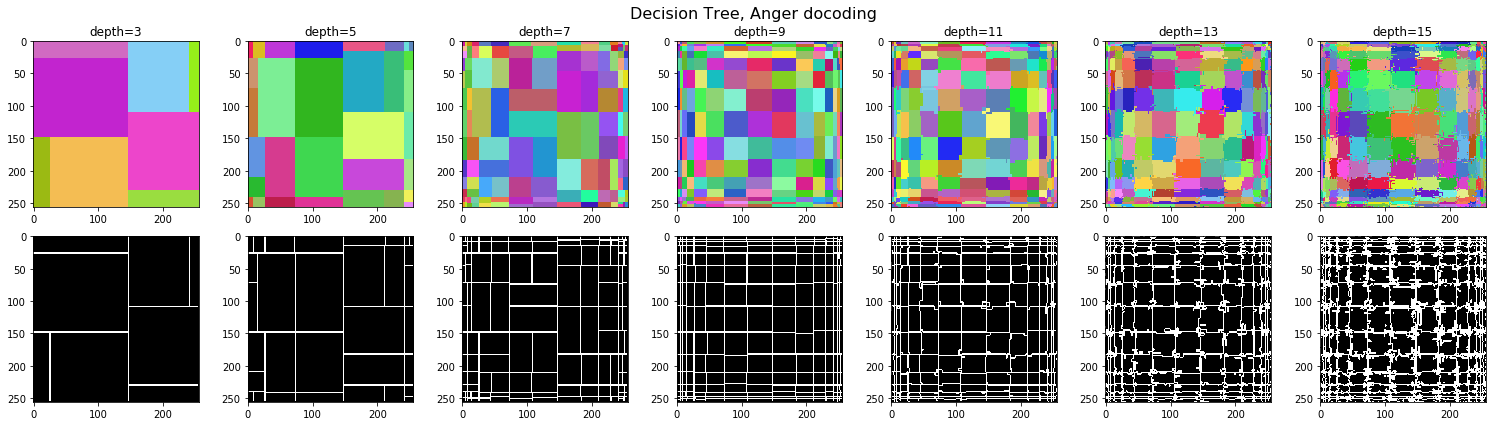

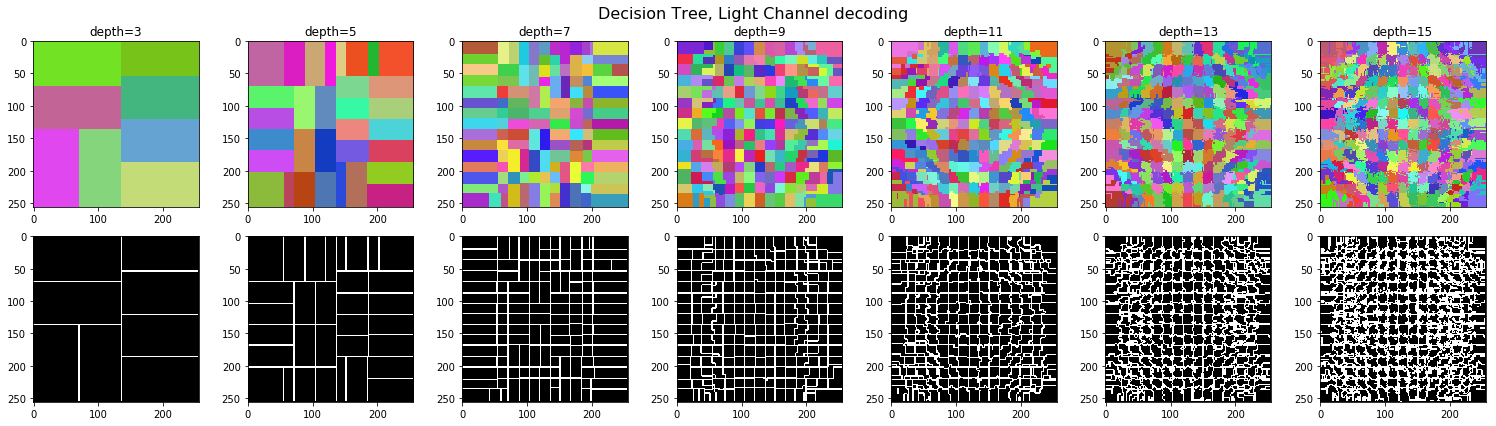

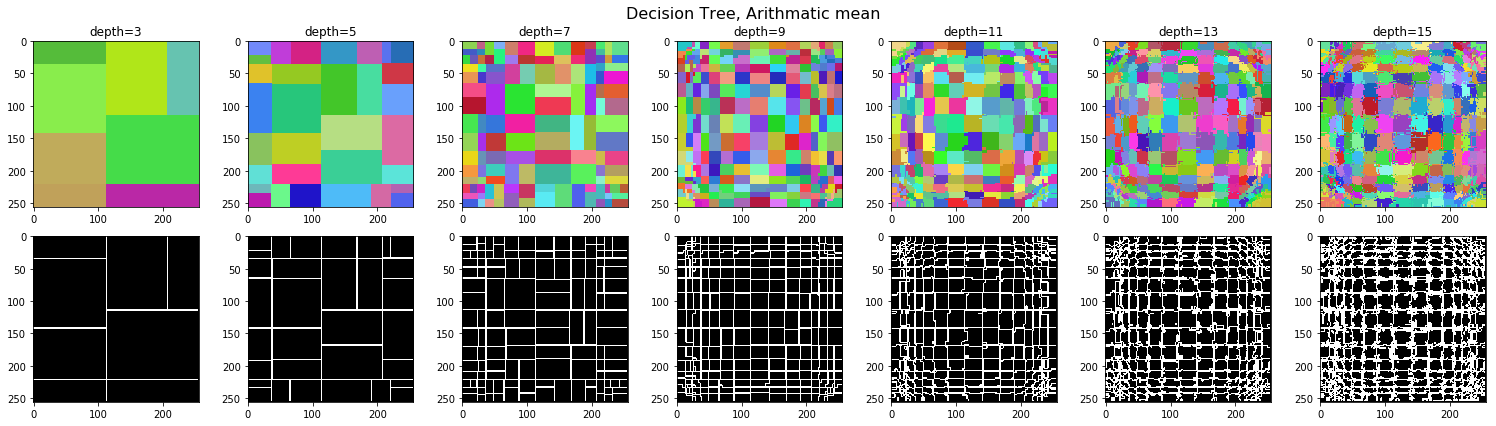

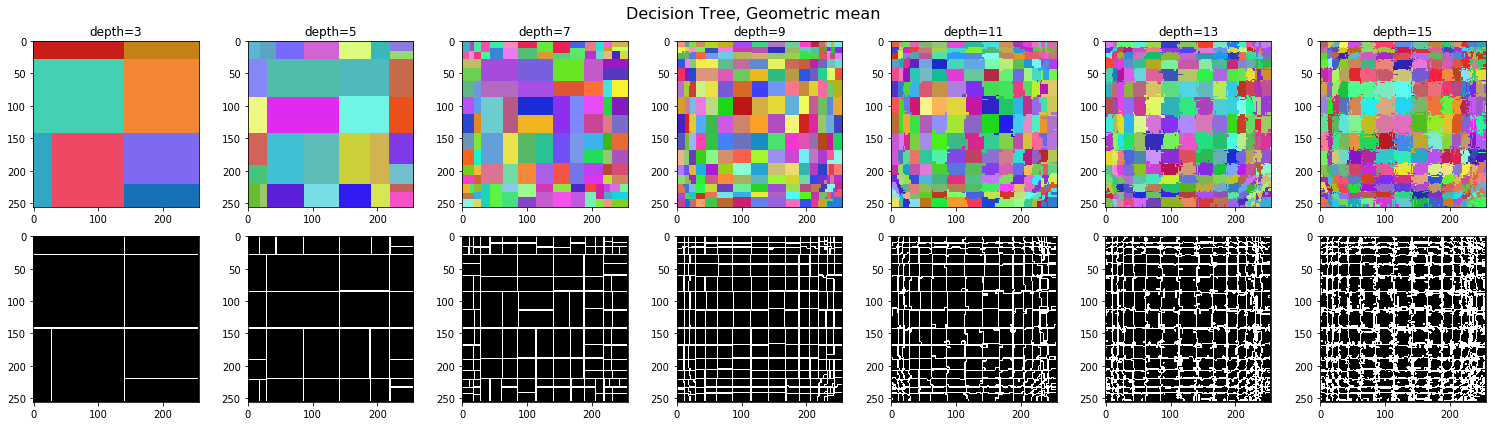

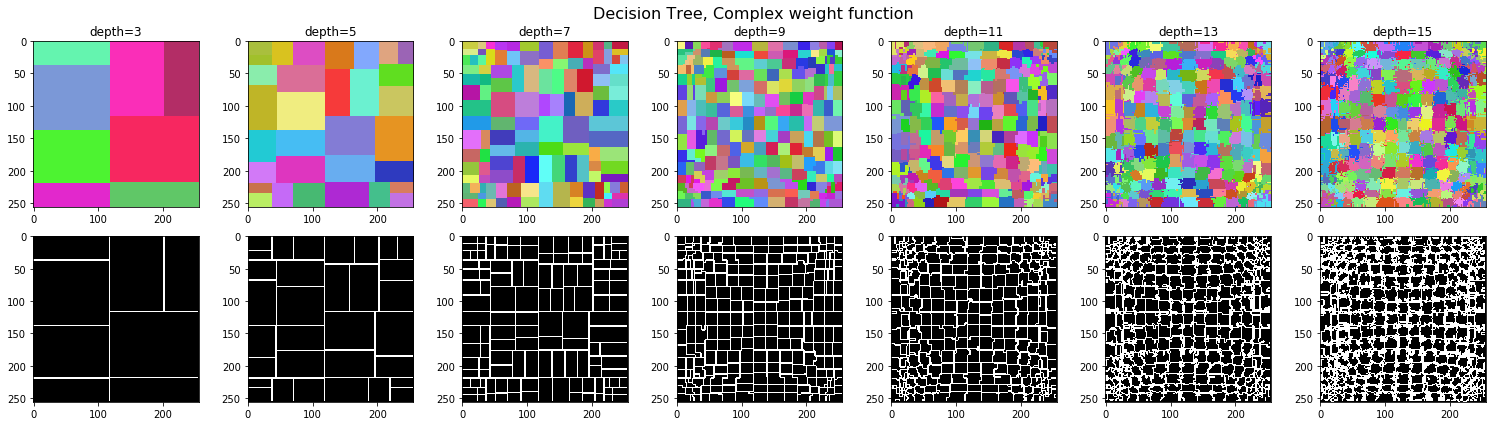

In [146]:
#for X, notes in ((X_t,'Anger docoding'), ( X_b, 'Light Channel decoding'), \
#                 (X_a,'Arithmatic mean'), (X_g,'Geometric mean'), \
#                 (X_c,'Complex weight function')):
#    print ('=== %s ==='%notes)
#    clf = test_tree_classifier2(X, y, index_train, index_test,depth=[3,5,7,9,11,13,15])
###############################################################################################
    
for X, notes in ((X_t,'Anger docoding'), ( X_b, 'Light Channel decoding'), \
                 (X_a,'Arithmatic mean'), (X_g,'Geometric mean'), \
                 (X_c,'Complex weight function')):
    print ('=== %s ==='%notes)
    
    depth=[3,5,7,9,11,13,15]
    scale = 3
    fig, ax = plt.subplots(2,len(depth), figsize=(len(depth)*scale, 2*scale))
    fig.suptitle("Decision Tree, " + notes, fontsize=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    
    for index, n in enumerate(depth):
        clf = test_tree_classifier2(X, y, index_train, index_test, depth = n)
        lut_pred = plot_prediction_boundary3(clf, cmap=random_cmap(), title='depth='+str(n), ax=ax[0,index])
        ax[1,index].imshow(generate_grid(lut_pred), cmap='gray')
     

<b> saved output <b>
***
=== Anger docoding ===  
accuracy from tree classification (max_depth=3): 0.034884  
accuracy from tree classification (max_depth=5): 0.120963  
accuracy from tree classification (max_depth=7): 0.342024  
accuracy from tree classification (max_depth=9): 0.495984  
accuracy from tree classification (max_depth=11): 0.494771  
accuracy from tree classification (max_depth=13): 0.489220  
accuracy from tree classification (max_depth=15): 0.478017  
=== Light Channel decoding ===  
accuracy from tree classification (max_depth=3): 0.035106  
accuracy from tree classification (max_depth=5): 0.127993  
accuracy from tree classification (max_depth=7): 0.370813  
accuracy from tree classification (max_depth=9): 0.522532  
accuracy from tree classification (max_depth=11): 0.550785  
accuracy from tree classification (max_depth=13): 0.553190  
accuracy from tree classification (max_depth=15): 0.543750  
=== Arithmatic mean ===  
accuracy from tree classification (max_depth=3): 0.035894  
accuracy from tree classification (max_depth=5): 0.129021  
accuracy from tree classification (max_depth=7): 0.371535  
accuracy from tree classification (max_depth=9): 0.567011  
accuracy from tree classification (max_depth=11): 0.575658  
accuracy from tree classification (max_depth=13): 0.573797  
accuracy from tree classification (max_depth=15): 0.564211  
=== Geometric mean ===  
accuracy from tree classification (max_depth=3): 0.035801  
accuracy from tree classification (max_depth=5): 0.127758  
accuracy from tree classification (max_depth=7): 0.374490  
accuracy from tree classification (max_depth=9): 0.572743  
accuracy from tree classification (max_depth=11): 0.579033  
accuracy from tree classification (max_depth=13): 0.575791  
accuracy from tree classification (max_depth=15): 0.565983  
=== Complex weight function ===  
accuracy from tree classification (max_depth=3): 0.035682  
accuracy from tree classification (max_depth=5): 0.131426  
accuracy from tree classification (max_depth=7): 0.372240  
accuracy from tree classification (max_depth=9): 0.559724  
accuracy from tree classification (max_depth=11): 0.571219  
accuracy from tree classification (max_depth=13): 0.569655  
accuracy from tree classification (max_depth=15): 0.560229  

=== Anger docoding ===
accuracy from tree classification (max_depth=11): 0.494771
=== Light Channel decoding ===
accuracy from tree classification (max_depth=11): 0.550785
=== Arithmatic mean ===
accuracy from tree classification (max_depth=11): 0.575658
=== Geometric mean ===
accuracy from tree classification (max_depth=11): 0.579033
=== Complex weight function ===
accuracy from tree classification (max_depth=11): 0.571219


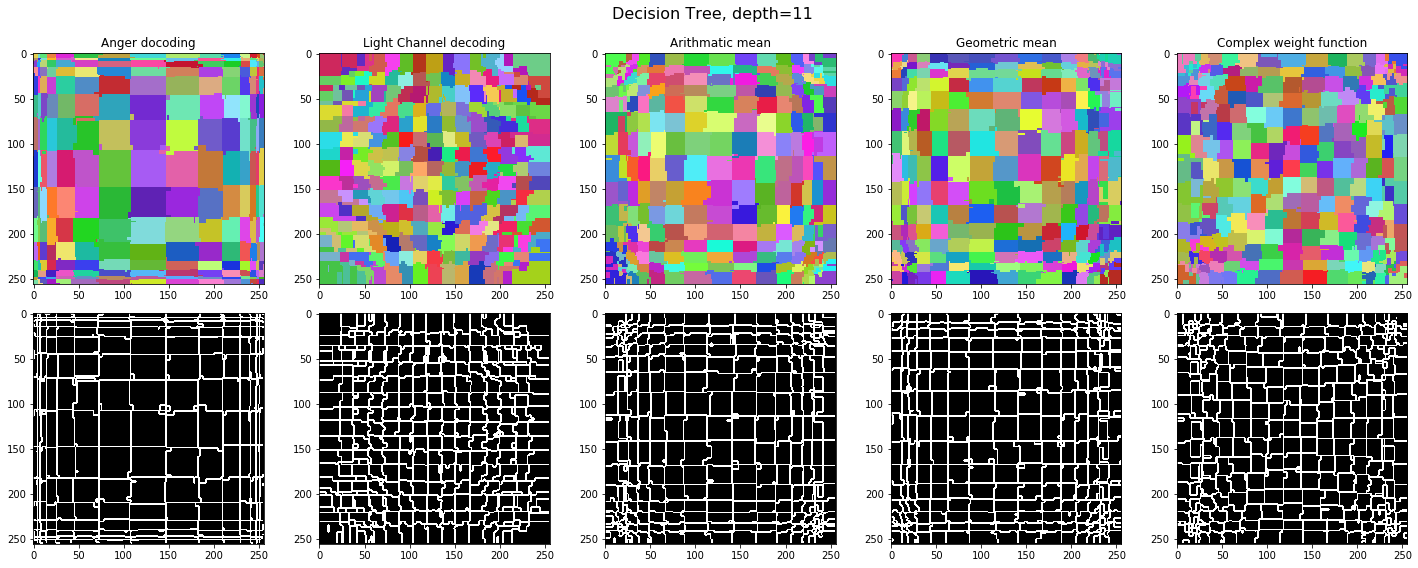

In [153]:
# plot the results using depth = 11

fig, ax = plt.subplots(2,5, figsize=(20, 8))
fig.suptitle("Decision Tree, depth=11", fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.9)

for index, (X, notes) in enumerate(((X_t,'Anger docoding'), ( X_b, 'Light Channel decoding'), \
                 (X_a,'Arithmatic mean'), (X_g,'Geometric mean'), \
                 (X_c,'Complex weight function'))):
    print ('=== %s ==='%notes)
    clf1 = test_tree_classifier2(X, y, index_train, index_test, depth=11)
    lut_pred = plot_prediction_boundary3(clf1, cmap=random_cmap(), title=notes, ax=ax[0,index])
    ax[1,index].imshow(generate_grid(lut_pred), cmap='gray')

* <b>Using tree classification algorithm with one output variable, the unique pixel/scintillator index, the accuracy could reach 0.57 for all three decoding techniques that combine the Anger and Light Channel results. The results are slightly improved from the tree classification with two output variables in x and y directions respectively.</b>

####  
#### 6.3 pixel discrimination using Naive Bayes method
***


In [66]:
# Fitting Naive Bayes
from sklearn.naive_bayes import GaussianNB


In [71]:
def NB(X, y, index_train, index_test):
    '''
    output y is the unique pixel index pixel_xy
    '''

    X_train = X[index_train]
    X_test = X[index_test]

    nb = GaussianNB()
    nb.fit(X_train, y[index_train])
    pixel_xy_pred = nb.predict(X_test)

    accuracy = sum(y[index_test]==pixel_xy_pred) / index_test.size
    print('accuracy from Naive Bayes: %f' % (accuracy))
        
    return nb

=== Anger docoding ===
accuracy from Naive Bayes: 0.353661
=== Light Channel decoding ===
accuracy from Naive Bayes: 0.456312
=== Arithmatic mean ===
accuracy from Naive Bayes: 0.490407
=== Geometric mean ===
accuracy from Naive Bayes: 0.507546
=== Complex weight function ===
accuracy from Naive Bayes: 0.495081


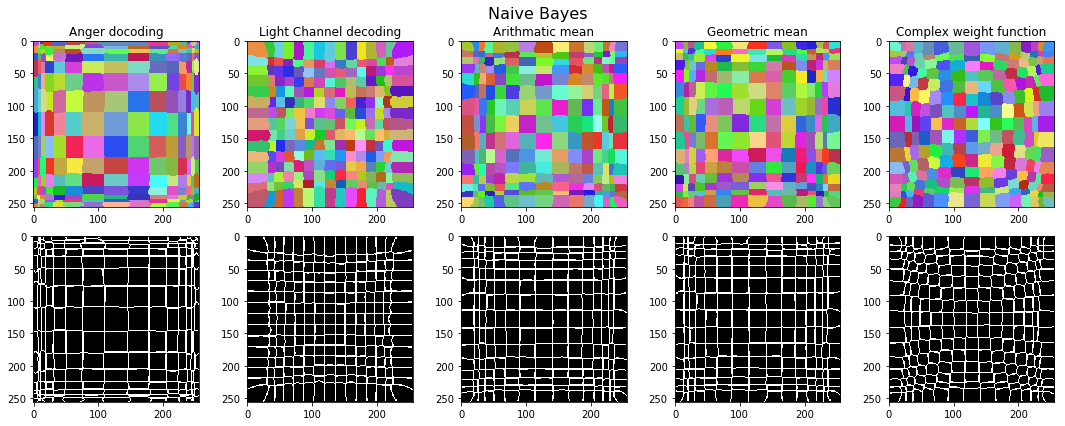

In [138]:

fig, ax = plt.subplots(2,5, figsize=(15, 6))
fig.suptitle("Naive Bayes", fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.9)

for index, (X, notes) in enumerate( ((X_t,'Anger docoding'), ( X_b, 'Light Channel decoding'), \
                 (X_a,'Arithmatic mean'), (X_g,'Geometric mean'), \
                 (X_c,'Complex weight function')) ):
    print ('=== %s ==='%notes)
    clf = NB(X, y, index_train, index_test)
    lut_pred = plot_prediction_boundary3(clf, cmap=random_cmap(), title=notes, ax=ax[0,index])
    ax[1,index].imshow(generate_grid(lut_pred), cmap='gray')
    
 

* <b>The Naive Bayes result is not good as the tree classification.</b>  
=== Anger docoding ===  
accuracy from Naive Bayes: 0.353661  
=== Light Channel decoding ===  
accuracy from Naive Bayes: 0.456312  
=== Arithmatic mean ===  
accuracy from Naive Bayes: 0.490407  
=== Geometric mean ===  
accuracy from Naive Bayes: 0.507546  
=== Complex weight function ===  
accuracy from Naive Bayes: 0.495081  


####  
#### 6.4 pixel discrimination using KNN method
***

In [8]:
from sklearn.neighbors import KNeighborsClassifier


In [9]:
def KNN(X, y, index_train, index_test, neighbors=3):
    '''
    output y is the unique pixel index pixel_xy
    '''

    X_train = X[index_train]
    X_test = X[index_test]

    knn = KNeighborsClassifier(n_neighbors=neighbors, metric='minkowski', p=2)
    knn.fit(X_train, y[index_train])
    pixel_xy_pred = knn.predict(X_test)

#    accuracy = sum(y[index_test]==pixel_xy_pred) / index_test.size
#    print('accuracy from KNN (neighbors=%d): %f' % (neighbors,accuracy))
    print("accuracy from KNN (neighbors=%d): %f" % (neighbors, metrics.accuracy_score(y[index_test], pixel_xy_pred)))
        
    return knn

=== Anger docoding ===
accuracy from KNN (neighbors=3): 0.360820
accuracy from KNN (neighbors=5): 0.423465
accuracy from KNN (neighbors=7): 0.447979
accuracy from KNN (neighbors=8): 0.455545
accuracy from KNN (neighbors=11): 0.468547
=== Light Channel decoding ===
accuracy from KNN (neighbors=3): 0.449038
accuracy from KNN (neighbors=5): 0.504813
accuracy from KNN (neighbors=7): 0.524787
accuracy from KNN (neighbors=8): 0.530616
accuracy from KNN (neighbors=11): 0.540968
=== Arithmatic mean ===
accuracy from KNN (neighbors=3): 0.473951
accuracy from KNN (neighbors=5): 0.528884
accuracy from KNN (neighbors=7): 0.548379
accuracy from KNN (neighbors=8): 0.553558
accuracy from KNN (neighbors=11): 0.563511
=== Geometric mean ===
accuracy from KNN (neighbors=3): 0.475696
accuracy from KNN (neighbors=5): 0.531825
accuracy from KNN (neighbors=7): 0.551183
accuracy from KNN (neighbors=8): 0.556743
accuracy from KNN (neighbors=11): 0.565044
=== Complex weight function ===
accuracy from KNN (neig

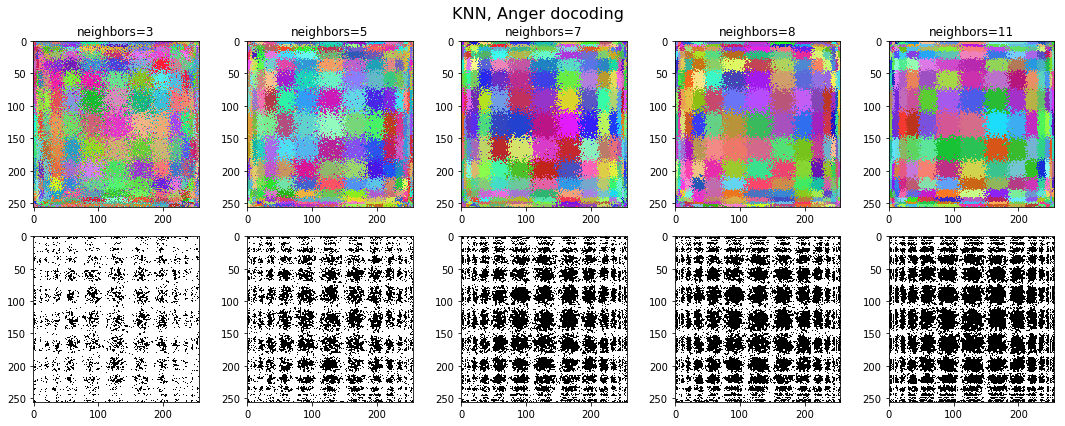

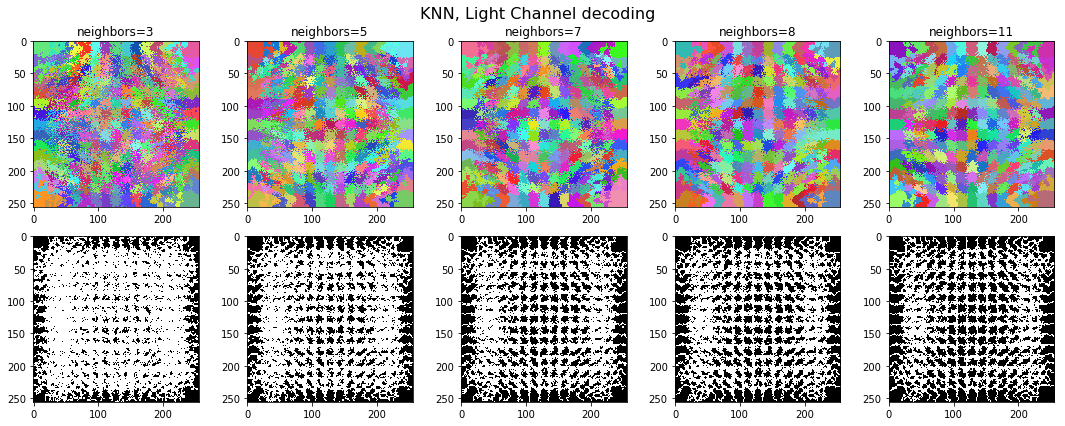

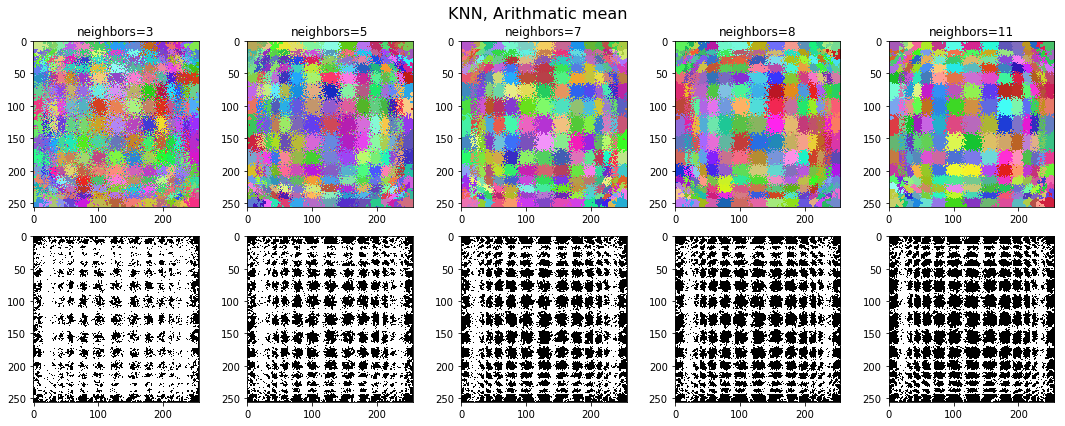

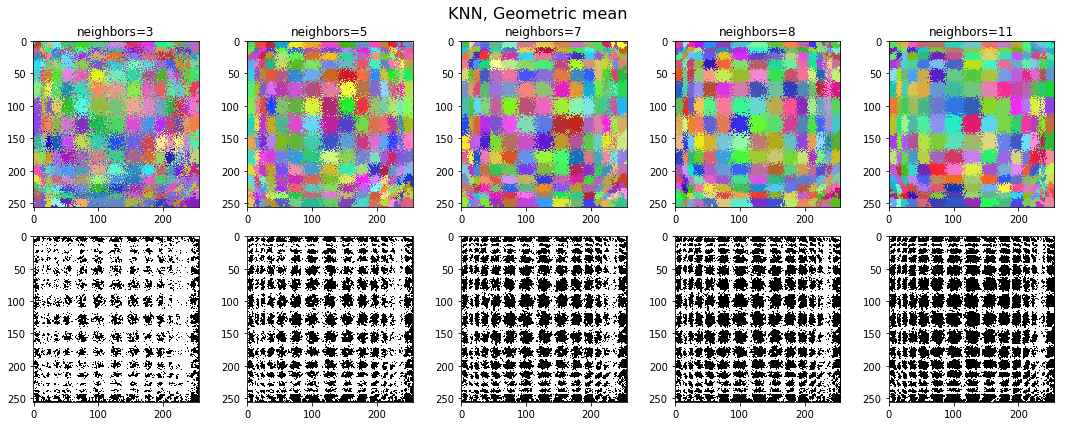

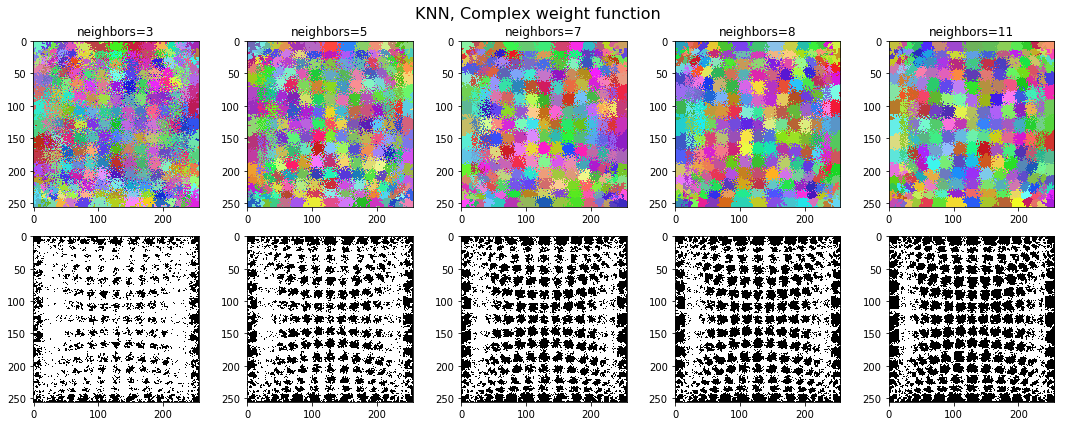

In [137]:
for X, notes in ((X_t,'Anger docoding'), ( X_b, 'Light Channel decoding'), \
                 (X_a,'Arithmatic mean'), (X_g,'Geometric mean'), \
                 (X_c,'Complex weight function')):
    print ('=== %s ==='%notes)
    
    neighbor_range  = [3,5,7,8,11]
    scale = 3
    fig, ax = plt.subplots(2,len(neighbor_range), figsize=(len(neighbor_range)*scale, 2*scale))
    fig.suptitle("KNN, "+notes, fontsize=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    
    for index, n in enumerate(neighbor_range):
        clf = KNN(X, y, index_train, index_test, neighbors = n)
        lut_pred = plot_prediction_boundary3(clf, cmap=random_cmap(), title='neighbors='+str(n), ax=ax[0,index])
        ax[1,index].imshow(generate_grid(lut_pred), cmap='gray')
 

=== Anger docoding ===
accuracy from KNN (neighbors=8): 0.455545
accuracy from KNN (neighbors=11): 0.468547
=== Light Channel decoding ===
accuracy from KNN (neighbors=8): 0.530616
accuracy from KNN (neighbors=11): 0.540968
=== Arithmatic mean ===
accuracy from KNN (neighbors=8): 0.553558
accuracy from KNN (neighbors=11): 0.563511
=== Geometric mean ===
accuracy from KNN (neighbors=8): 0.556743
accuracy from KNN (neighbors=11): 0.565044
=== Complex weight function ===
accuracy from KNN (neighbors=8): 0.548189
accuracy from KNN (neighbors=11): 0.557451


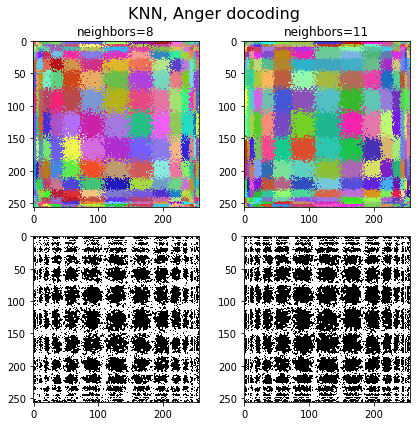

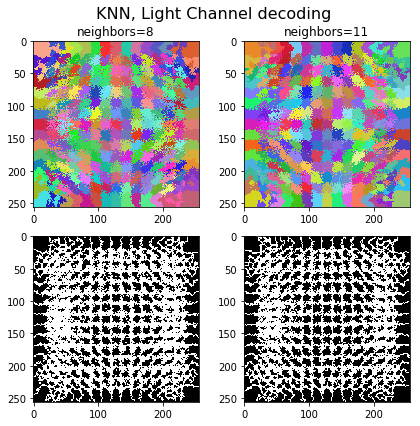

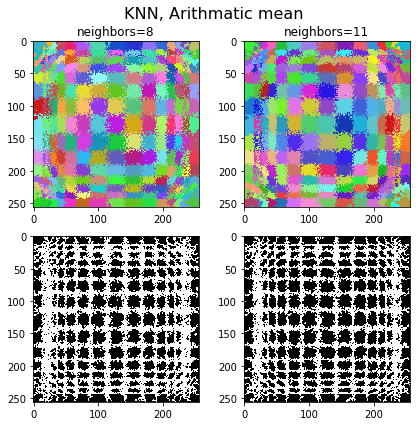

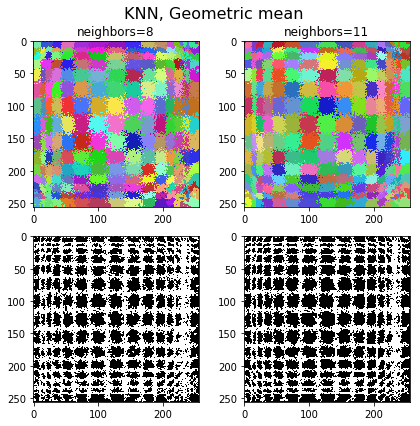

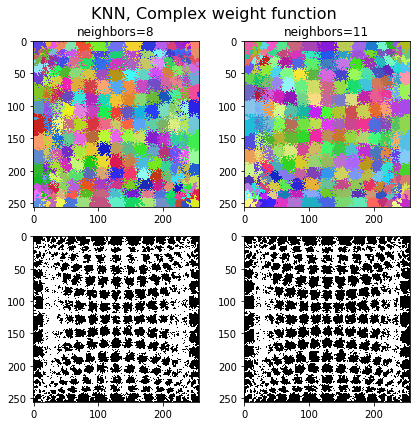

In [13]:
for X, notes in ((X_t,'Anger docoding'), ( X_b, 'Light Channel decoding'), \
                 (X_a,'Arithmatic mean'), (X_g,'Geometric mean'), \
                 (X_c,'Complex weight function')):
    print ('=== %s ==='%notes)
    
    neighbor_range  = [8,11]
    scale = 3
    fig, ax = plt.subplots(2,len(neighbor_range), figsize=(len(neighbor_range)*scale, 2*scale))
    fig.suptitle("KNN, "+notes, fontsize=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    
    for index, n in enumerate(neighbor_range):
        clf = KNN(X, pixel_xy, index_train, index_test, neighbors = n)
        lut_pred = plot_prediction_boundary3(clf, cmap=random_cmap(), title='neighbors='+str(n), ax=ax[0,index])
        ax[1,index].imshow(generate_grid(lut_pred), cmap='gray')

#        print("Accuracy:", metrics.accuracy_score(y[index_test], clf.predict(X[index_test])))
        

####  
#### 6.5 pixel discrimination using SVM method
***
The previous studies are using the Anger decoding or Light Channel decoding techniques, in which the input variables are the combinations of original input variables (photosensor counts). Here we will use the SVM algorithm along with the original input variables to see whether better prediction could be made from the original variables.  
<b>Since one of the SVM's advantage is that it works more effectively on high dimensional spaces, which means with more input variables, it works better. With the Anger decoding or Light Channel decoding techniques, the 36 input variables are reduced to only two variables. which might not be suitable for SVM algorithm. 


* Before we trying using the 36 original input variables, we are trying with the preprosessed input variables anyway.


In [8]:
from sklearn.svm import SVC

In [17]:
def test_svm(X, y, index_train, index_test):
    '''
    output y is the unique pixel index pixel_xy
    '''

    X_train = X[index_train]
    X_test = X[index_test]

    clf = SVC(kernel='rbf', random_state=1, gamma='auto')
    clf.fit(X_train, y[index_train])
    pixel_xy_pred = clf.predict(X_test)

    accuracy = sum(y[index_test]==pixel_xy_pred) / index_test.size
    
    print('accuracy score: %f' % (metrics.accuracy_score(y[index_test], pixel_xy_pred)))
        
    return clf


=== Anger docoding ===


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy score: 0.103310
=== Light Channel decoding ===


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy score: 0.101310


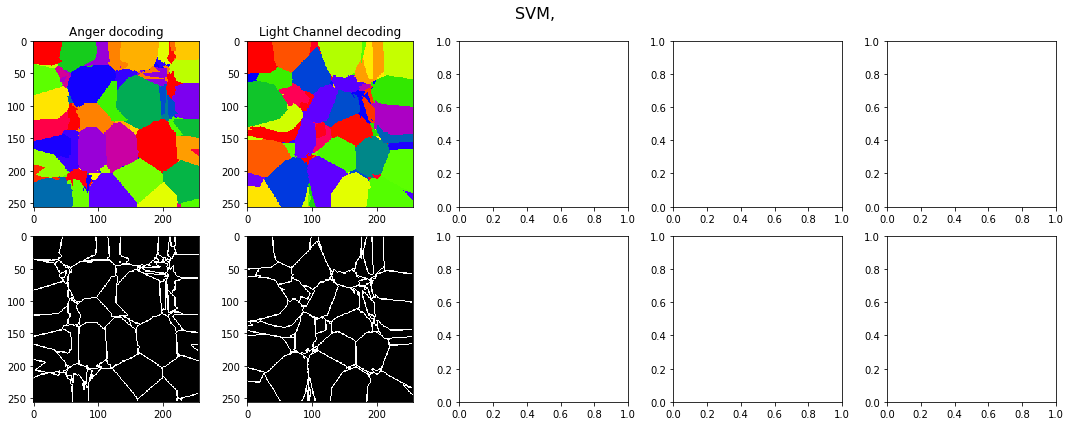

In [18]:
fig, ax = plt.subplots(2,5, figsize=(15, 6))
fig.suptitle("SVM, ", fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.9)

#for index, (X, notes) in enumerate( ((X_t,'Anger docoding'), ( X_b, 'Light Channel decoding'), \
#                 (X_a,'Arithmatic mean'), (X_g,'Geometric mean'), \
#                 (X_c,'Complex weight function')) ):
for index, (X, notes) in enumerate( ((X_t,'Anger docoding'), ( X_b, 'Light Channel decoding'))):
    
    print ('=== %s ==='%notes)
    
    clf = test_svm1(X, pixel_xy, index_train[1:10000], index_test[1:10000], kernel='rbf')
    lut_pred = plot_prediction_boundary3(clf, cmap='prism', title=notes,  ax=ax[0,index])
    ax[1,index].imshow(generate_grid(lut_pred), cmap='gray')


In [10]:
def test_svm1(X, y, index_train, index_test, kernel='linear'):
    '''
    output y is the unique pixel index pixel_xy
    '''

    X_train = X[index_train]
    X_test = X[index_test]

    clf = SVC(kernel=kernel, random_state=1)
    clf.fit(X_train, y[index_train])
    pixel_xy_pred = clf.predict(X_test)

    accuracy = sum(y[index_test]==pixel_xy_pred) / index_test.size
    
    print('accuracy score: %f' % (metrics.accuracy_score(y[index_test], pixel_xy_pred)))
        
    return clf


=== Anger docoding ===
accuracy score: 0.102010
Processing time for fitting 31.957430 sec
Processing time for predicting 199.254848 sec
=== Light Channel decoding ===
accuracy score: 0.101910
Processing time for fitting 31.315839 sec
Processing time for predicting 199.606273 sec


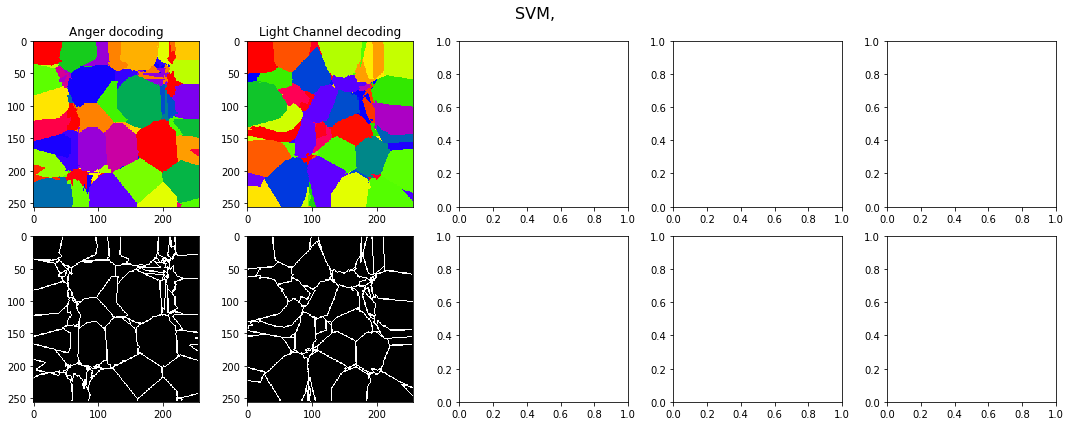

In [14]:
fig, ax = plt.subplots(2,5, figsize=(15, 6))
fig.suptitle("SVM, ", fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.9)


#for index, (X, notes) in enumerate( ((X_t,'Anger docoding'), ( X_b, 'Light Channel decoding'), \
#                 (X_a,'Arithmatic mean'), (X_g,'Geometric mean'), \
#                 (X_c,'Complex weight function')) ):
for index, (X, notes) in enumerate( ((X_t,'Anger docoding'), ( X_b, 'Light Channel decoding'))):
    
    print ('=== %s ==='%notes)
    t0 = time.time()
    clf1 = test_svm1(X, pixel_xy, index_train[1:10000], index_test[1:10000], kernel='linear')
    t1 = time.time()
    print ('Processing time for fitting %f sec'%(t1-t0))
    t0 = t1
    lut_pred = plot_prediction_boundary3(clf1, cmap='prism', title=notes,  ax=ax[0,index])
    ax[1,index].imshow(generate_grid(lut_pred), cmap='gray')
    t1 = time.time()
    print ('Processing time for predicting %f sec'%(t1-t0))
    


In [126]:
plot_prediction_boundary3(clf1, cmap='prism', title=notes,  ax=ax[0,index])

array([[  0,   0,   0, ...,  29,  29,  29],
       [  0,   0,   0, ...,  29,  29,  29],
       [  0,   0,   0, ...,  29,  29,  29],
       ...,
       [196, 196, 196, ..., 222, 222, 222],
       [196, 196, 196, ..., 222, 222, 222],
       [196, 196, 196, ..., 222, 222, 222]], dtype=int64)

=== Anger docoding ===


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy score: 0.053305
Processing time for fitting 33.816037 sec
Processing time for predicting 205.682369 sec
=== Light Channel decoding ===


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy score: 0.057606
Processing time for fitting 34.190889 sec
Processing time for predicting 203.321519 sec


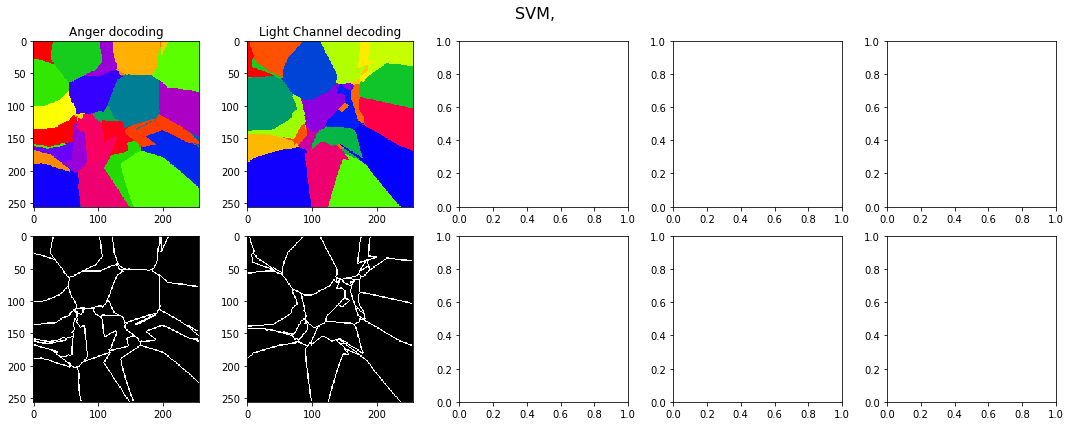

In [13]:
fig, ax = plt.subplots(2,5, figsize=(15, 6))
fig.suptitle("SVM, ", fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.9)


#for index, (X, notes) in enumerate( ((X_t,'Anger docoding'), ( X_b, 'Light Channel decoding'), \
#                 (X_a,'Arithmatic mean'), (X_g,'Geometric mean'), \
#                 (X_c,'Complex weight function')) ):
for index, (X, notes) in enumerate( ((X_t,'Anger docoding'), ( X_b, 'Light Channel decoding'))):
    
    print ('=== %s ==='%notes)
    t0 = time.time()
    clf1 = test_svm1(X, pixel_xy, index_train[1:10000], index_test[1:10000], kernel='sigmoid')
    t1 = time.time()
    print ('Processing time for fitting %f sec'%(t1-t0))
    t0 = t1
    lut_pred = plot_prediction_boundary3(clf1, cmap='prism', title=notes,  ax=ax[0,index])
    ax[1,index].imshow(generate_grid(lut_pred), cmap='gray')
    t1 = time.time()
    print ('Processing time for predicting %f sec'%(t1-t0))
    


###  
* <b>Obviously the SVM algorithm is much slower than the other ML algorithms. Using partical (small percentage) trainning data as we did above shows very poor results that the accuracy is only a few percent.</b>
* <b>A extra testing of the SVM algorithm using linear kernel with the complete trainning data set has been carried out, shown [here](https://github.com/yzhang3000/Machine-Learning-Techniques-on-PET-block-detector-development/blob/master/python/svm_test1.md) (svm_test1).</b>


##  
## Continued in [Part 2-3](https://github.com/yzhang3000/Machine-Learning-Techniques-on-PET-block-detector-development/blob/master/python/PET_detector_block_02-3.md)